In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Преамбула

In [1]:
import os
import sys
import random

In [2]:
import numpy as np

In [3]:
import torch
from torch.utils.data import Dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
from torchvision.transforms import InterpolationMode

In [ ]:
from svetlanna import SimulationParameters
from svetlanna import elements
from svetlanna import Wavefront

In [ ]:
# датасеты волновых фронтов
from svetlanna.transforms import ToWavefront, GaussModulation
from src.wf_datasets import DatasetOfWavefronts  # <- Dataset Class to test

In [8]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# 1. Необработанный датасет [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

Загружаем набор данных из `torchvision` в выбранный каталог и создаём обучающие и тестовые наборы данных.

In [ ]:
# инициализация директории для датасета
data_filepath = './data'

In [ ]:
import ssl
# Чтобы решить проблему с сертификатами при загрузке набора данных с помощью TorchVision,
# воспользуйтесь решением: https://github.com/pytorch/pytorch/issues/33288#issuecomment-954160699
ssl._create_default_https_context = ssl._create_unverified_context

## 1.1. Обучение

In [11]:
mnist_train_ds = torchvision.datasets.MNIST(
    root=data_filepath,
    train=True,  # for train dataset
    download=True,
    # transform=transforms.ToTensor()  # <- transforms images to tensors
)

len(mnist_train_ds)

60000

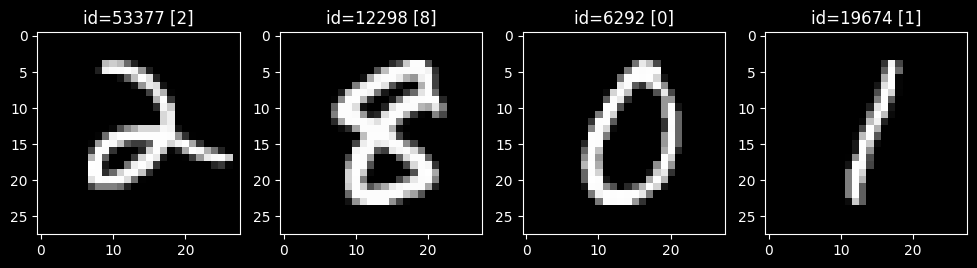

In [ ]:
# визуализация нескольких изображения
n_examples= 4

# случайные индексы изображений
random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

fig, axs = plt.subplots(1, n_examples, figsize=(n_examples * 3, 3))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, target = mnist_train_ds[ind_train]

    axs[ind_ex].set_title(f'id={ind_train} [{target}]')
    axs[ind_ex].imshow(image, cmap='gray')

plt.show()

Each image is of the size `torch.Size([1, 28, 28])`

## 1.2. Типы для датасета

In [ ]:
# какой тип объектов?
type(mnist_train_ds)

torchvision.datasets.mnist.MNIST

In [ ]:
# проверить, является ли созданный объект экземпляром класса Dataset
assert isinstance(mnist_train_ds, Dataset)

# 2. Датасеты волновых фронтов

## 2.1. `SimulationParameters`

In [ ]:
# параметры моделирования
x_nodes = 100
y_nodes = x_nodes

x_size_m = 20 * 1e-2  # [m]
y_size_m = x_size_m  # [m]

wavelength = 1000 * 1e-9  # [m]

In [ ]:
sim_params = SimulationParameters(
    axes={
        'W': torch.linspace(-x_size_m / 2, x_size_m / 2, x_nodes),
        'H': torch.linspace(-y_size_m / 2, y_size_m / 2, y_nodes),
        'wavelength': wavelength,  # здесь задаём одну длину волны
    }
)

## 2.2. Класс датасета волновых фронтов с помощью `transforms.Compose`

### 2.2.1. Трансформации каждого изображения из исходного датасета

In [ ]:
resize_y = int(y_nodes / 3)
resize_x = int(x_nodes / 3)  # shape для transforms.Resize

pad_top = int((y_nodes - resize_y) / 2)
pad_bottom = y_nodes - pad_top - resize_y
pad_left = int((x_nodes - resize_x) / 2)
pad_right = x_nodes - pad_left - resize_x  # параметры для transforms.Pad


image_transform_for_ds03 = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # отступы нужны для приведение в соответствие розмеров
      ToWavefront(modulation_type='phase'),  # <- тип модуляции
      GaussModulation(sim_params=sim_params, fwhm_x=5e-2, fwhm_y=8e-2)
  ]
)

### 2.2.2. Проверка предупреждений

In [ ]:
image_transform_for_ds_check = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      GaussModulation(sim_params=sim_params, fwhm_x=5e-2, fwhm_y=8e-2)
  ]
)

mnist_wf_train_ds_check = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # датасет изображений
    transformations=image_transform_for_ds_check,  # трансформация изображений
    sim_params=sim_params
)

/Users/giyuu/science-phd/git-projects/SVETlANNa/svetlanna/transforms.py:144: UserWarning: A shape of an input Wavefront does not match with SimulationParameters! Gauss was not applied!
  warnings.warn(
/Users/giyuu/science-phd/git-projects/SVETlANNa.docs/pipelines/src/wf_datasets.py:155: UserWarning: An output object is not of the Wavefront type!
  warnings.warn(
/Users/giyuu/science-phd/git-projects/SVETlANNa.docs/pipelines/src/wf_datasets.py:163: UserWarning: A shape of a resulted Wavefront does not match with SimulationParameters!
  warnings.warn(


### 2.2.3. Новый датасет волновых фронтов

In [ ]:
# тренирововчный датасет
mnist_wf_train_ds03 = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # датасет изображений
    transformations=image_transform_for_ds03,  # трансформация изображений
    sim_params=sim_params
)

#### Examples of items

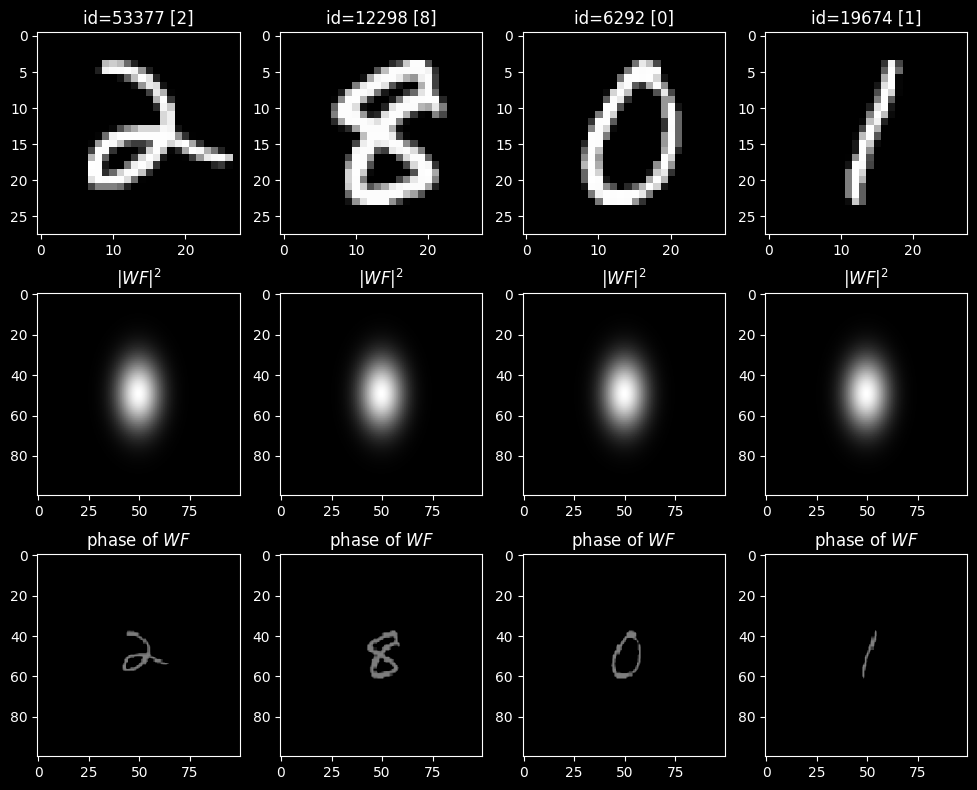

In [ ]:
# построение примеров изображений
n_lines = 3

fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = mnist_wf_train_ds03[ind_train]
    assert isinstance(wavefront, Wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1,
    )

    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase, cmap='gray',
        vmin=0, vmax=2 * torch.pi
    )

plt.show()